# Intro
This notebook shows how to upload model predicted segmentations to Datamint platform. This notebook is based on these documentations:
- [Running Experiments](https://sonanceai.github.io/datamint-python-api/running_experiments.html)
- [Datamint Experiment class](https://sonanceai.github.io/datamint-python-api/datamint.experiment.html)

In [18]:
from matplotlib import pyplot as plt
import os
import nibabel as nib
import numpy as np

# Configuration

In [ ]:
%pip install git+https://github.com/SonanceAI/datamint-python-api

If you haven't already, you need to setup your api key:

In [ ]:
!datamint-config --api-key MY_API_KEY

In [9]:
from datamintapi import APIHandler

api = APIHandler()

# Setup-up example Project and data(optional)

creating project

In [16]:
from datamintapi.examples import ProjectMR

ProjectMR.create(project_name='Example Project MR')

'65239f76-a325-432d-bd87-8714a58867f9'

creating a synthetic segmentation and saving it to 'segmentation.nii.gz'

In [19]:
# The uploaded resource 'emri_small.dcm' has shape (10,64,64) (#frame, H,W).
# default nifti files have shape (W,H,#frame). We need to swap the axes.

seg_array = np.zeros((64, 64, 10), dtype=np.uint8)
seg_array[0:16, 0:16, 0] = 1
seg_array[32:, 50, 1] = 1 # horizontal line
seg_nii = nib.Nifti1Image(seg_array, np.eye(4))
nib.save(seg_nii, "segmentation1.nii.gz")

The segmentation looks like this:

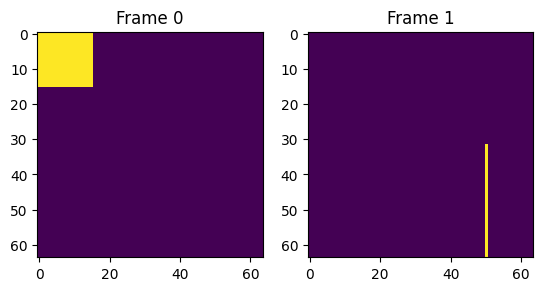

In [20]:
_,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(seg_array[:,:,0])
ax1.set_title('Frame 0')
ax2.imshow(seg_array[:,:,1])
ax2.set_title('Frame 1');

# Upload model predicted segmentations

Let's assume the predictions for a single instance have already been made and stored inside a file called `segmentation1.nii.gz`.  
We need to:
1. Create a new experiment
2. Associate a model with this experiment (can be an empty model)
3. Upload the segmentation file to the experiment

## 1. Create a new experiment

In [1]:
from datamintapi import Experiment

exp = Experiment(name='Experiment 1',
                 project_name='Example Project MR',
                 allow_existing=True,  # If an experiment with the same name exists, allow_existing=True returns the existing experiment
                 #  dry_run=True,  # Set dry_run=True to avoid uploading the results to the platform
                 auto_log=False,
                 )

## 2. Associate a model with this experiment

In [ ]:
from torch import nn

exp.log_model(nn.Module())  # Log a dummy model

## 3. Upload the segmentation file to the experiment

In [ ]:
exp.log_segmentation_prediction()